# Monarch Butterfly Migrations
I am going to be analyzing the migration patterns of monarch butterflies. Specifically, I am going to look at 2020.<br/>
_Note:_ All of the analysis on what we are looking at is going to be done at the end of this notebook. If you have no interest in the process of gathering and processing the data, and just want to understand the results of this analysis, scroll to the bottom.
## Step 0: Steup Environment

In [1]:
import geopandas as gpd
import pandas as pd
import os
import pathlib
import calendar
import cartopy.crs as ccrs
import panel as pn
import hvplot.pandas
from matplotlib import colormaps
import time
import zipfile
from getpass import getpass
from glob import glob
import pygbif.occurrences as occ
import pygbif.species as species
import requests
import json
from io import BytesIO

### Setup Data Directory

In [2]:
data_directory = os.path.join(
    pathlib.Path.home(),
    "earthlab",
    "data",
    "monarch-migration"
)
print(f'You can find all downloaded data here: {data_directory}')

# Make directory only if it doesn't exist
os.makedirs(data_directory, exist_ok=True)

You can find all downloaded data here: /Users/keingtobin/earthlab/data/monarch-migration


## Step 1: Data Wrangle

We need to grab a couple different types of data. <br/><br/>
First, we are going to be grabbing species data from GBIF. This will contain data will contain species observation for the monarch butterfly from all around the world.

In [3]:
# This code was provided by the instructors of GEOG4463.
reset = True

# Request and store username
if (not ('GBIF_USER' in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

# Securely request and store password
if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')

# Request and store account email address
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

GBIF username: keingtobin
GBIF password: ········
GBIF email: zahu8482@colorado.edu


In [4]:
# Get the species key of the Monarch Butterfly
backbone = species.name_backbone(name="Danaus plexippus")
species_key = backbone['usageKey']
species_key

5133088

In [5]:
# Only download the data once
gbif_pattern = os.path.join(data_directory, '*.csv')
if not glob(gbif_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
            f'speciesKey = {species_key}',
            'hasCoordinate = TRUE',
            'year = 2020'
        ])
        # Create the download key
        os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]
    # Wait for the download to build
    download_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(download_key)['status']
    while not wait == 'SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    # Download GBIF data
    download_info = occ.download_get(
        os.environ['GBIF_DOWNLOAD_KEY'],
        path=data_directory
    )

    # Unzip GBIF data
    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=data_directory)

# Find the extracted .csv file path (take the first result)
gbif_path = glob(gbif_pattern)[0]

Finally, we can load the downloaded data into a dataframe!

In [6]:
#### Load the data into a pandas dataframe
monarch_obs_df = pd.read_csv(
    gbif_path,
    delimiter='\t',
    index_col=0,
    usecols=[0,21,22,31]
)
# Look at the data
monarch_obs_df.head()

,decimalLatitude,decimalLongitude,month
gbifID,,,
5868288697,33.678099,-117.961945,7.0
5868252356,17.133770,-62.580842,12.0
5868102933,-8.922512,-139.567251,7.0
5867985570,42.020163,-71.198013,8.0
5867861837,20.498180,-86.844666,12.0


In [7]:
# Convert the pandas dataframe into a geopandas dataframe
monarch_obs_gdf = (
    gpd.GeoDataFrame(
        monarch_obs_df,
        geometry=gpd.points_from_xy(
            monarch_obs_df.decimalLongitude,
            monarch_obs_df.decimalLatitude),
        crs="EPSG:4326")
    # Select desired columns
    [['month','geometry']]
)

monarch_obs_gdf.head()


,month,geometry
gbifID,,
5868288697,7.0,POINT (-117.96194 33.6781)
5868252356,12.0,POINT (-62.58084 17.13377)
5868102933,7.0,POINT (-139.56725 -8.92251)
5867985570,8.0,POINT (-71.19801 42.02016)
5867861837,12.0,POINT (-86.84467 20.49818)


Now, lets get the ecoregion data loaded into python. 

<Axes: >

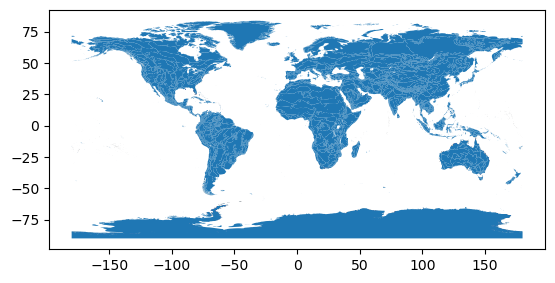

In [8]:
# Ecoregion download URL
ecoregion_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"

# Create a directory to save the ecoregion data
ecoregion_directory = os.path.join(data_directory, 'ecoregions')
os.makedirs(ecoregion_directory, exist_ok=True)

# Define the path that the ecoregion data is going to be stored in
ecoregion_path = os.path.join(ecoregion_directory, 'ecoregions.shp')

# Only download and save the data once
if not os.path.exists(ecoregion_path):
    ecoregion_geodataframe = gpd.read_file(ecoregion_url)
    ecoregion_geodataframe.to_file(ecoregion_path)

# Open the downloaded ecoregion data and store as a geodataframe
ecoregion_gdf = (
    gpd.read_file(ecoregion_path)
    # Select only wanted columns
    [['OBJECTID', 'ECO_NAME', 'SHAPE_AREA', 'geometry']]
    .rename(columns={
        'OBJECTID' : 'ecoregion'
    })
    .set_index('ecoregion')
)

# Check out the plot
ecoregion_gdf.plot()

## Step 2: Normalize Data
Now that we have all the data we need, we need to do a couple of things to properly work with it. The first thing we need to do is preform a spatial join on our data. In other words, we are going create a geodataframe that combines the ecoregions and observation data only where there are observations within an ecoregion.

In [9]:
gbif_ecoregion_gdf = (
    ecoregion_gdf
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(monarch_obs_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        monarch_obs_gdf,
        how='inner', # Inner join because we only want the rows with full match
        predicate='contains') # We want to find the areas with the vertices in them
    [['month']] # Select only columns we want
    .reset_index() # Pull index out and add new index
    .rename(columns={'index':'ecoregion'}) # Rename the old index to ecoregion
)   # Shout outs to Elsa Culler for those last two lines of code, very helpful.

# Look at data
gbif_ecoregion_gdf.head()

,ecoregion,month
0,17.0,7.0
1,17.0,7.0
2,17.0,8.0
3,17.0,6.0
4,17.0,9.0


Now that we've got that all sorted, we can count the observations in each ecoregion for each month.

In [10]:
occurrence_df = (
    gbif_ecoregion_gdf
    # For each ecoregion, for each month...
    .groupby(['ecoregion','month'])
    # ...count the number of occurrences
    .agg(occurrences=('month', 'count')) 
)


# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df['occurrences'] > 1]


# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby('ecoregion')
    .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby('month')
    .mean()
)

Now, we need to normalize the data.

In [11]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df
    / mean_occurrences_by_month
    / mean_occurrences_by_ecoregion
)
# Look at the normalized data
occurrence_df.head()

occurrences  norm_occurrences
ecoregion month                               
17.0      6.0             10          0.003789
          7.0            101          0.017133
          8.0            110          0.019196
          9.0             58          0.011953
          10.0             9          0.002551

## Step 3: Plotting

In [12]:
# Simplify the geometry to speed up processing
ecoregion_gdf['geometry'] = ecoregion_gdf.simplify(0.05, preserve_topology=False)

# Change the CRS to Mercator for mapping
ecoregion_gdf = ecoregion_gdf.to_crs(ccrs.Mercator())

# Join the occurrences with the plotting GeoDataFrame
occurrence_gdf = ecoregion_gdf.join(occurrence_df)

# Get the plot bounds so they don't change with the slider
xmin, ymin, xmax, ymax = occurrence_gdf.total_bounds

# Create a widget to interact with the slider
slider_widget = pn.widgets.DiscreteSlider(
    options={
        calendar.month_name[i]: i for i in range(1,13)
    }
)

# Plot occurrence by ecoregion and month
migration_plot = (
    occurrence_gdf
    .hvplot(
        c='norm_occurrences',
        colormap="coolwarm",
        groupby='month',
        # Use background tiles
        geo=True, crs=ccrs.Mercator(), tiles='CartoLight',
        title="Monarch Butterfly Occurrences",
        xlim=(xmin, xmax), ylim=(ymin, ymax),
        frame_height=600, frame_width = 600,
        widgets={'month': slider_widget},
        widget_location='bottom'
    )
)

# Save the plot
migration_plot.save('monarch_plot.html', embed=True)

In [13]:
migration_plot

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widgets={'month': DiscreteSlider(f...})
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(formatter='%d', name='month', options={'January': 1, ...}, value=1)

## Step 4: Analysis

The first thing that really jumps out to be is the observations of Monarch Butterflies worldwide. I have always assumed Monarchs only lived in North and South America. However, according to the [Monarch Joint Venture](https://monarchjointventure.org/monarch-biology/global-distribution), the butterflies are found in over 90 countries. That being said, if you scroll through the dates on the interactive plot, you can see the butterflies outside of North America not following the same migration patterns. <br/><br/>
The data we see here confirms the known migration patterns of the North American Monarch Butterflies. According to the [U.S. Forest Service](https://www.fs.usda.gov/wildflowers/pollinators/Monarch_Butterfly/migration/index.shtml), Monarch Butterflies are the only butterfly known to make two way migration patterns, similar to birds. This is because the Monarch cannot survive the cold winter months of the northern climate. <br/><br/>
We see the density of the butterflies during the winter months high in the mountainous regions of central Mexico, and along the Pacific Coast of California. Then, as the weather begins to warm, we see that density move North. The butterflies overwintering in California will head more North-East, towards the rockies. <br/><br/>
Something important to keep in mind is the source of this data. [GBIF](https://www.gbif.org/) species observation data is gathered from all over, including citizen scientists. This could cause some error in observations recorded if everyone is not being careful to make sure they correctly identified a Monarch. There are other species of butterfly that are similar enough to the Monarch that at first glance, it may seem you are looking at a Monarch. Another source of error may be from the COVID-19 Pandemic. With everything shut down there was likely less work being done attempting to observe and log various species.<br/><br/>
Lastly, something interesting to note is the density of Monarch observations at the Southern tip of Florida in January. At first, I assumed this was error relating to the data source. However after researching it further, it appears that there is a [year round population](https://www.flawildflowers.org/monarchs-and-milkweed/) of the butterfly in South Florida.

## Bonus: Number of Observations
The main reason I chose to look at the year 2020 for most of my analysis was because the COVID-19 Pandemic had [some positive effects](https://www.sciencedirect.com/science/article/pii/S2773049224000205) on the environment. This could have had some short term positive effects on the Monarch Butterfly population, and I would like to take a look at that. <br/><br/>
First thing I need to do is download other years of data.

In [14]:

# Define years we want (already have 2020)
years = [2019,2021,2022,2023]
# For each year, build and run a query
for year in years:
    query = occ.download([
        f'speciesKey = {species_key}',
        'hasCoordinate = TRUE',
        f'year = {year}'
        ])
    download_key = query[0]
    wait = occ.download_meta(download_key)
    while not wait == 'SUCCEEDED':
        wait = occ.download_meta(download_key)['status']
        time.sleep(5)

    download_info = occ.download_get(
        download_key,
        path=data_directory
    )

    with zipfile.ZipFile(download_info['path']) as download_zip:
        download_zip.extractall(path=data_directory)

INFO:Your download key is 0005964-251025141854904
INFO:Download file size: 1767667 bytes
INFO:On disk at /Users/keingtobin/earthlab/data/monarch-migration/0005964-251025141854904.zip
INFO:Your download key is 0005966-251025141854904
INFO:Download file size: 2884409 bytes
INFO:On disk at /Users/keingtobin/earthlab/data/monarch-migration/0005966-251025141854904.zip
INFO:Your download key is 0005970-251025141854904
INFO:Download file size: 2807896 bytes
INFO:On disk at /Users/keingtobin/earthlab/data/monarch-migration/0005970-251025141854904.zip
INFO:Your download key is 0005972-251025141854904
INFO:Download file size: 2803755 bytes
INFO:On disk at /Users/keingtobin/earthlab/data/monarch-migration/0005972-251025141854904.zip


In [15]:
# Now, for each csv of gbif data we have, count the number of observations and print that
for csv in glob(gbif_pattern):
    df = pd.read_csv(
        csv,
        delimiter='\t',
        usecols=['year']
    )
    #print(df['year'][0])
    print(f'There were {len(df)} observations in {df.year[0]}')

There were 41704 observations in 2021
There were 27365 observations in 2019
There were 40628 observations in 2022
There were 40975 observations in 2023
There were 32182 observations in 2020


Looks like my hypothesis may have been wrong. There actually is a spike in observations after 2020 (and a spike in 2020 compared to 2019). Many things could be causing this, and more than likely the number of observations has nothing to do with the actual population of the Monarch Butterflies. Still interesting to look at though, maybe there's more interest in citizen science after the pandemic so we're seeing more observations posted!